**This data set contains details of a bank's customers and the target variable is a binary variable reflecting the fact whether the customer left the bank (closed his account) or he continues to be a customer.**

In [1]:
!pip install shap

     |████████████████████████████████| 358kB 12.9MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491633 sha256=9a610fb7bb1f303246f2c988d299343a507e73060640f95741714a4eb66c979f
  Stored in directory: /root/.cache/pip/wheels/15/27/f5/a8ab9da52fd159aae6477b5ede6eaaec69fd130fa0fa59f283
Successfully built shap


In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline

from sklearn.metrics import confusion_matrix, plot_roc_curve, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler,RobustScaler
import tensorflow as tf
from tensorflow.keras import Sequential, layers, callbacks
from keras.wrappers.scikit_learn import KerasClassifier


In [3]:
df = pd.read_csv("Churn_Modelling.csv")
df.sample(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
1329,1330,15645572,Calabresi,743,France,Female,40,6,0.00,1,1,0,28280.80,1
1225,1226,15733387,Pham,707,Spain,Female,53,6,109663.47,1,1,1,52110.45,0
1912,1913,15576644,Lin,687,Germany,Female,29,4,78939.15,1,1,0,122134.56,1
3686,3687,15665327,Cattaneo,706,France,Male,18,2,176139.50,2,1,0,129654.22,0
8521,8522,15579207,Watkins,545,France,Male,37,3,91184.01,1,1,0,105476.65,0
1531,1532,15715031,Davidson,600,France,Female,28,6,0.00,2,0,1,52193.23,0
5448,5449,15718912,Hsueh,608,Germany,Female,44,5,126147.84,1,0,1,132424.69,1
2647,2648,15687162,Clayton,461,France,Male,51,9,119889.84,1,0,0,56767.67,1
6797,6798,15811978,Trevisani,693,Germany,Male,46,2,104763.41,1,1,1,62368.33,0
6383,6384,15812040,Lorenzo,594,France,Male,36,6,153880.15,1,0,0,135431.72,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


No null values in the dataset. `CustomerId`,`Surname`,`RowNumber` do not seem insightful in the analysis. We will drop these columns.

In [5]:
df.drop(['CustomerId','Surname','RowNumber'],axis=1,inplace=True)

In [6]:
#Check unique values in Geography column and Gender column (the only two categorical columns)
for col in df:
    if df[col].dtypes=='object':
      print(f'{col}: {df[col].unique()}')

Geography: ['France' 'Spain' 'Germany']
Gender: ['Female' 'Male']


In [7]:
#Check distribution of the numeric data
df.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


The statistics in all columns look fine except `EstimatedSalary`, which has std of 57510 and min of 11.58. This may infer outliers or wrong data input. We will further visualize the distribution of the data

# Data cleaning

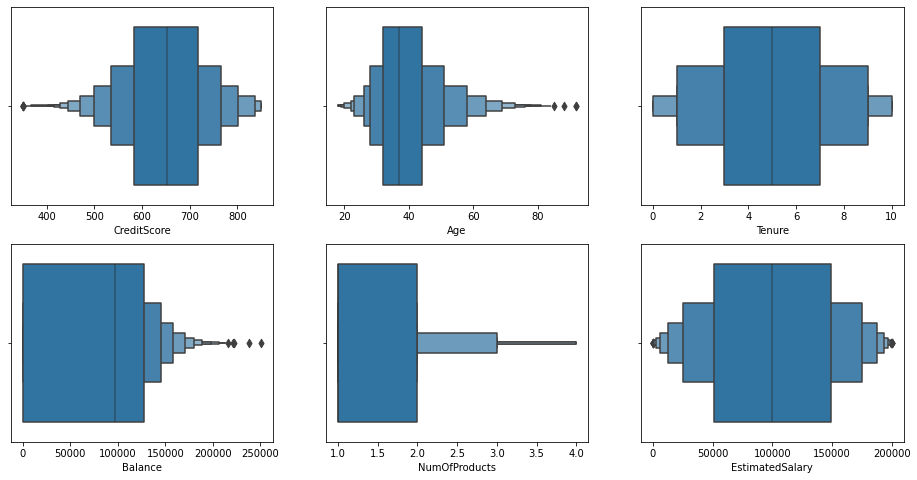

In [8]:
check_columns = ['CreditScore', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'EstimatedSalary']

plt.figure(figsize=(16,8))

for i, col in zip(range(231,237), check_columns):
  plt.subplot(i)
  sns.boxenplot(data=df, x=str(col))



**Removing outliers**

In [9]:
# Create a function to detect outliers using IQR method
def detect_outliers(df, column):
  Q1 = df[column].quantile(0.25)
  Q3 = df[column].quantile(0.75)
  IQR = Q3 - Q1
  lower_limit = Q1 - 1.5*IQR
  upper_limit = Q3 + 1.5*IQR

  return df[(df[column]<lower_limit)|(df[column]>upper_limit)]


In [10]:
#finding credit score outliers
credit_outliers = detect_outliers(df,'CreditScore')
credit_outliers

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
7,376,Germany,Female,29,4,115046.74,4,1,0,119346.88,1
942,376,France,Female,46,6,0.00,1,1,0,157333.69,1
1193,363,Spain,Female,28,6,146098.43,3,1,0,100615.14,1
1405,359,France,Female,44,6,128747.69,1,1,0,146955.71,1
1631,350,Spain,Male,54,1,152677.48,1,1,1,191973.49,1
1838,350,Germany,Male,39,0,109733.20,2,0,0,123602.11,1
1962,358,Spain,Female,52,8,143542.36,3,1,0,141959.11,1
2473,351,Germany,Female,57,4,163146.46,1,1,0,169621.69,1
2579,365,Germany,Male,30,0,127760.07,1,1,0,81537.85,1
8154,367,Spain,Male,42,6,93608.28,1,1,0,168816.73,1


In [11]:
#finding age outliers
age_outliers = detect_outliers(df,'Age')[df['Age']>77]
age_outliers

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
252,681,France,Female,79,0,0.00,2,0,1,170968.99,0
310,652,France,Female,80,4,0.00,2,1,1,188603.07,0
766,700,France,Female,82,2,0.00,2,0,1,182055.36,0
2458,513,Spain,Male,88,10,0.00,2,1,1,52952.24,0
3033,787,France,Female,85,10,0.00,2,1,1,116537.96,0
3387,537,Germany,Male,84,8,92242.34,1,1,1,186235.98,0
3531,408,France,Female,84,8,87873.39,1,0,0,188484.52,1
3651,732,France,Male,79,10,61811.23,1,1,1,104222.80,0
3994,809,Spain,Male,80,8,0.00,2,0,1,34164.05,0
4590,635,France,Female,78,6,47536.40,1,1,1,119400.08,0


We only saw outliers outside IQR in columns `CreditScore` and `Age`. We will drop all outliers in `CreditScore`. But for `Age`, we will just remove rows with age greater than 78.

In [12]:
# drop outlier rows
df.drop(pd.concat([age_outliers,credit_outliers]).index,inplace=True)

# Data visualization

Let's visualize our data and ifnd some insights

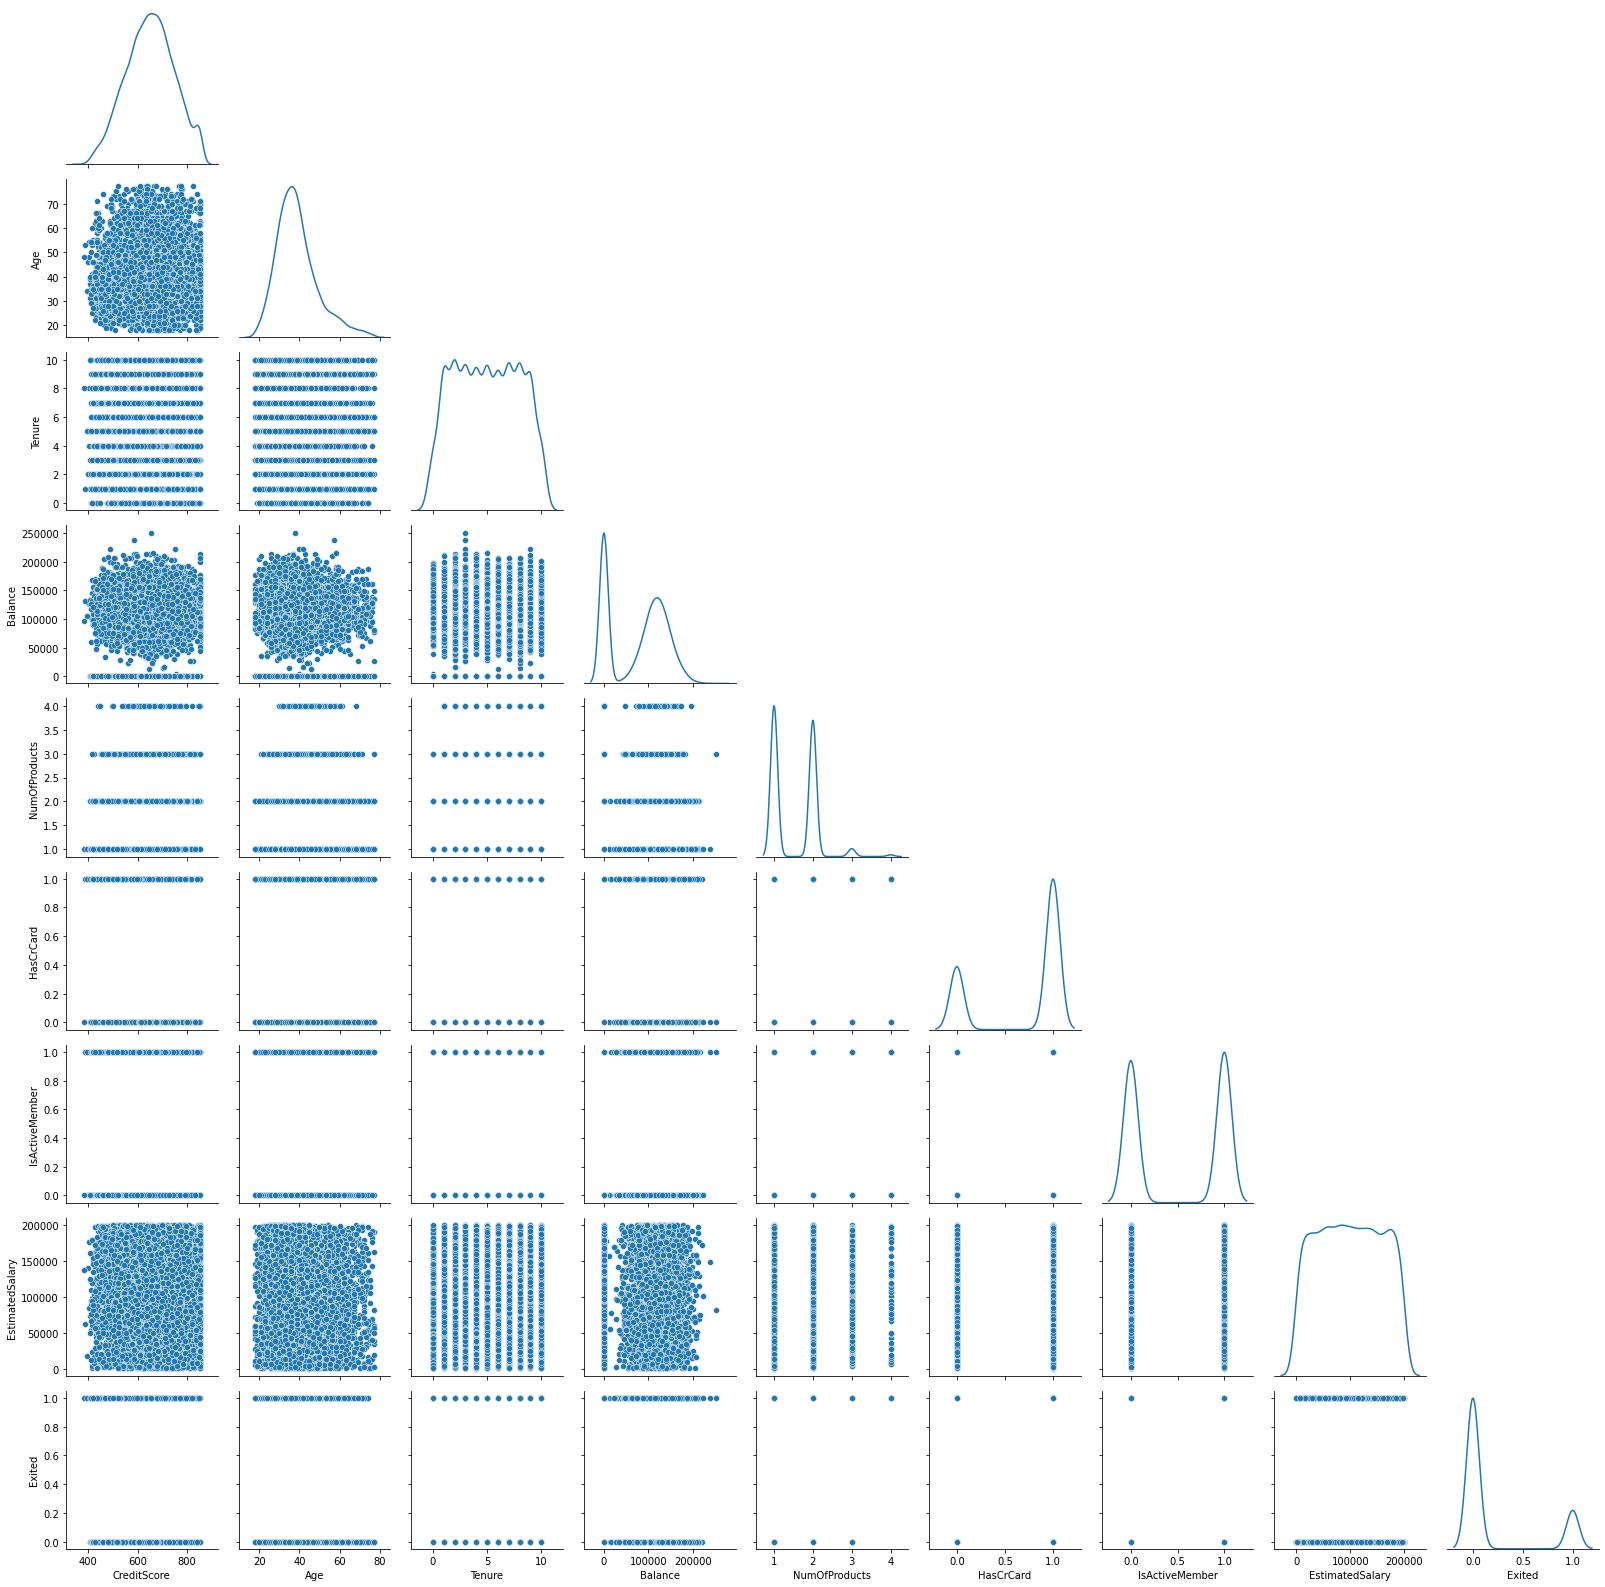

In [13]:
g = sns.PairGrid(df, diag_sharey=False, corner=True)
g.map_lower(sns.scatterplot)
g.map_diag(sns.kdeplot)

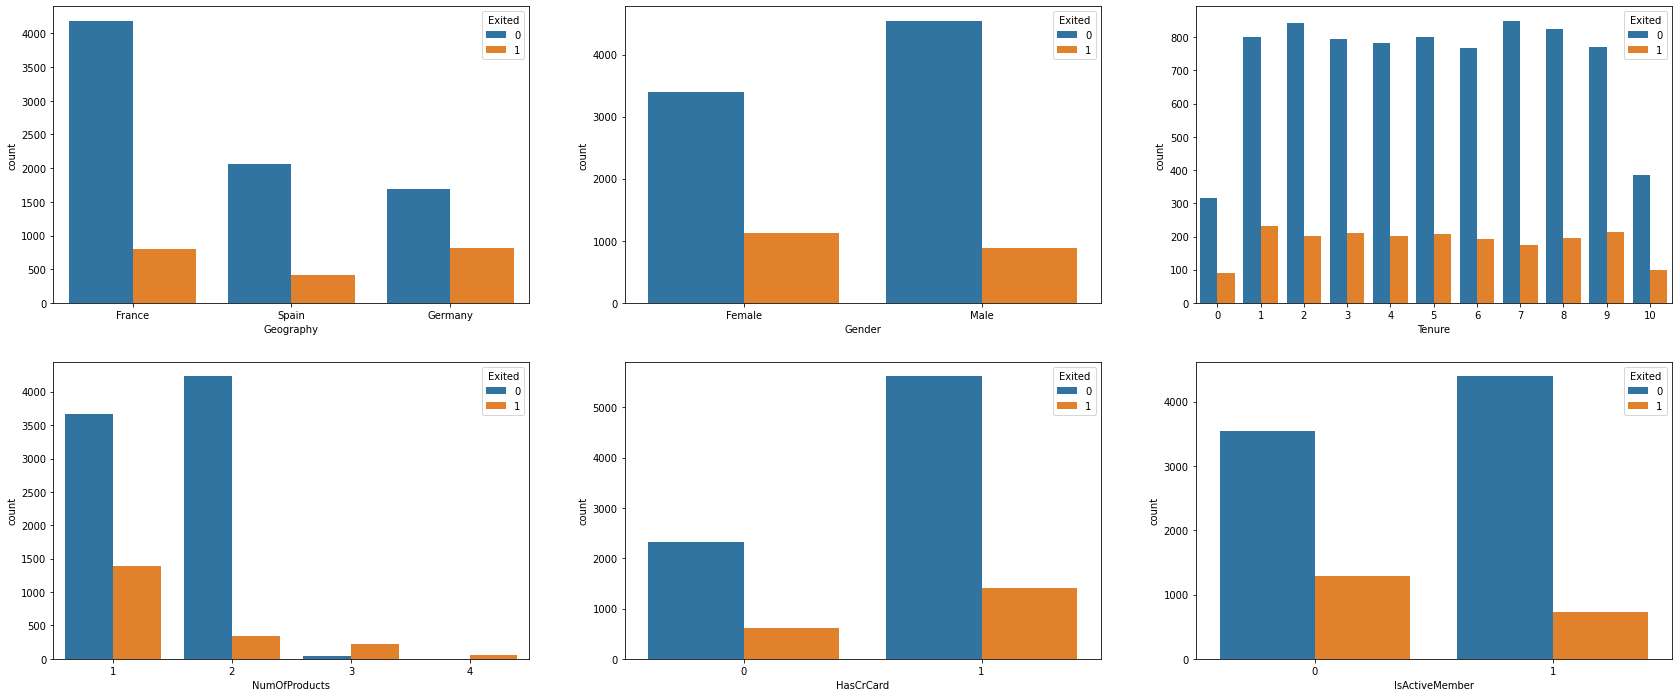

In [14]:
count_columns = ['Geography', 'Gender','Tenure','NumOfProducts', 'HasCrCard', 'IsActiveMember']


plt.figure(figsize=(29,12))

for i, col in zip(range(231,237), count_columns):
  plt.subplot(i)
  sns.countplot(data=df, x=str(col),hue='Exited')


Our data is very imbalanced with around 8000 to 2000 in the exited ratio. We'll need to resample the data for our training

Let's see the pairplot to see the relationship between variables

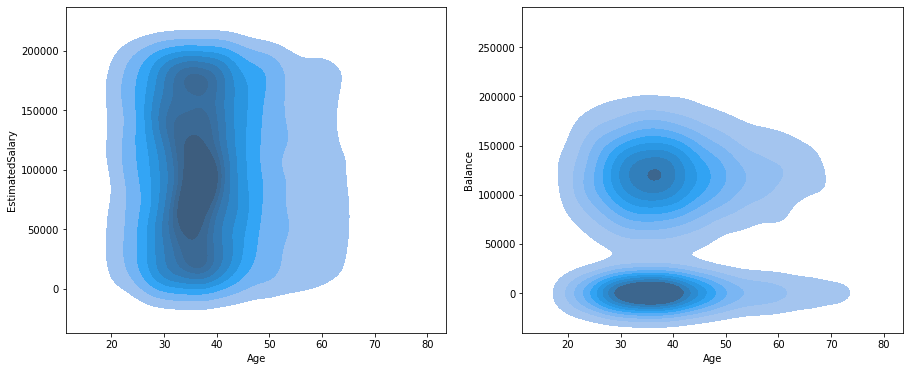

In [15]:
#Age and Balance, Age and EstimatedSalary

f1, axes1 = plt.subplots(1,2,figsize=(15,6))
sns.kdeplot(data=df, x='Age', y='EstimatedSalary',fill=True,ax=axes1[0])
sns.kdeplot(data=df, x='Age', y='Balance',fill=True,ax=axes1[1])

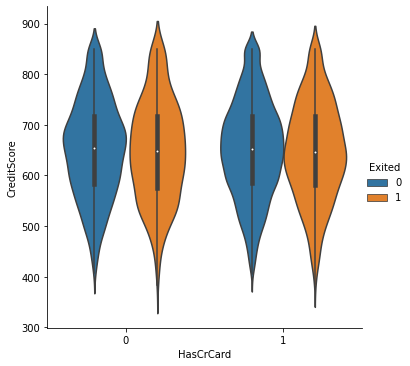

In [16]:
#Credit card ,Credit score and Exited

sns.catplot(x="HasCrCard", y='CreditScore', hue='Exited', data=df, kind='violin')

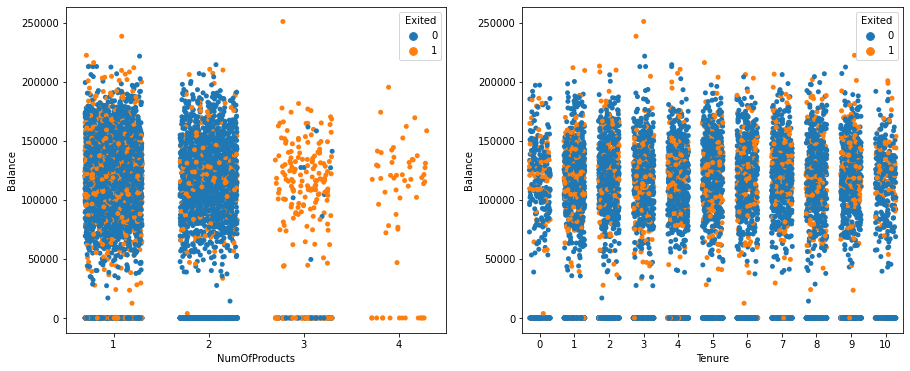

In [17]:
#Balance, NumofProducts, Excited relationship
f2, axes2 = plt.subplots(1,2,figsize=(15,6))
sns.stripplot(x='NumOfProducts', y='Balance', hue='Exited', data=df, jitter=0.3 ,ax=axes2[0])
sns.stripplot(x='Tenure', y='Balance', hue='Exited', data=df,jitter=0.3, ax=axes2[1])

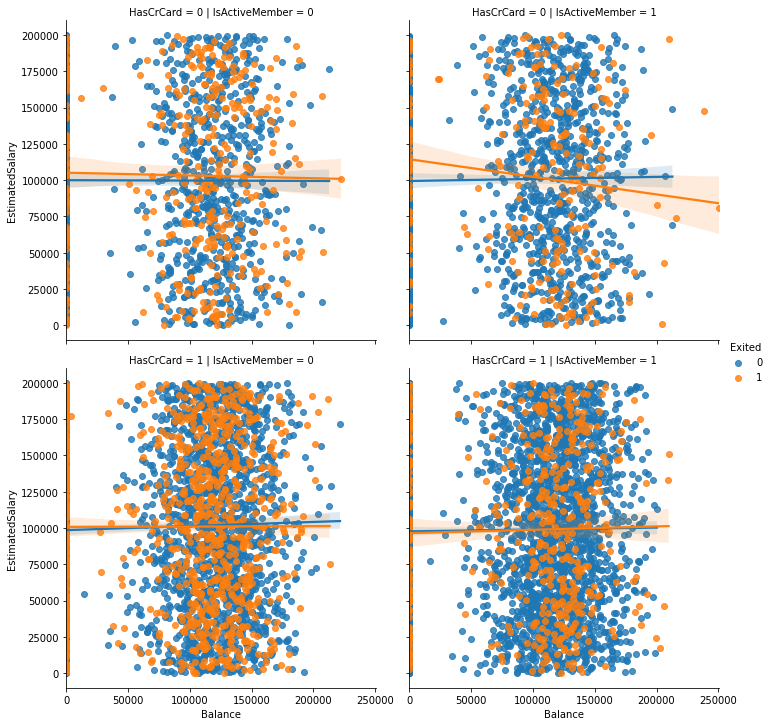

In [18]:
sns.lmplot(x='Balance', y='EstimatedSalary', hue='Exited',
           col='IsActiveMember', row='HasCrCard', data=df);

# Feature Engineering
We'll have to scale the numeric feature variables and encode categorical variables.

In [19]:
#Encoding the categorical variables

df = pd.get_dummies(df, columns=['Geography','Gender'],drop_first=True)

Now we'll do PCA to check if we can reduce the dimensionality

In [20]:
X = df.drop('Exited',axis=1)
y = df['Exited']

In [21]:
# Creating functions to plot the PCA graphs
def apply_pca(X, standardize=True):
    # Standardize
    if standardize:
        X = (X - X.mean(axis=0)) / X.std(axis=0)
    # Create principal components
    pca = PCA()
    X_pca = pca.fit_transform(X)
    # Convert to dataframe
    component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
    X_pca = pd.DataFrame(X_pca, columns=component_names)
    # Create loadings
    loadings = pd.DataFrame(
        pca.components_.T,  # transpose the matrix of loadings
        columns=component_names,  # so the columns are the principal components
        index=X.columns,  # and the rows are the original features
    )
    return pca, X_pca, loadings


def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=8, dpi=100)
    return axs

                        PC1       PC2       PC3  ...       PC9      PC10      PC11
CreditScore       -0.002036  0.001846  0.160260  ...  0.170936 -0.061307 -0.005648
Age               -0.086997 -0.252409  0.558684  ...  0.613350 -0.070955  0.043471
Tenure             0.019731  0.161888 -0.277997  ... -0.186947 -0.023070  0.006207
Balance           -0.598284 -0.261259 -0.131331  ... -0.070929  0.378431  0.633261
NumOfProducts      0.297613  0.640031  0.316428  ...  0.106584  0.464358  0.361860
HasCrCard         -0.001292  0.160306 -0.161920  ...  0.005737  0.035397  0.022859
IsActiveMember     0.031270 -0.267981  0.589230  ... -0.641417  0.000879 -0.017598
EstimatedSalary   -0.018129  0.140818 -0.071175  ...  0.018729 -0.045417 -0.015613
Geography_Germany -0.597729  0.274900  0.123542  ...  0.024271  0.370221 -0.636712
Geography_Spain    0.431915 -0.445792 -0.138549  ...  0.025686  0.701031 -0.243215
Gender_Male        0.019559 -0.201346 -0.233662  ...  0.360823  0.003478 -0.021102

[11

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f5d83e80890>,
      dtype=object)

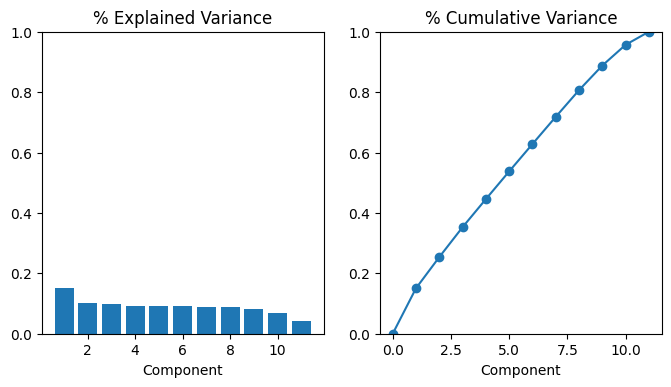

In [22]:
numerical_cols = X.select_dtypes(include=np.number).columns.tolist()
pca, X_pca, loadings = apply_pca(X.loc[:,numerical_cols]) 
print(loadings)
plot_variance(pca)

Each PC can only explain small variance.

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 120)

In [24]:
#Scaling the numeric variables
ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)
X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test = pd.DataFrame(X_test_scaled, columns=X_train.columns)

# Building an ANN for our training


In [25]:
# Create a function to create an ANN
def ANN(optimizer = 'rmsprop', loss='hinge'):

  model = Sequential([
      layers.Dense(12, input_shape=(11,), activation='relu'),
      layers.Dropout(0.6),
      layers.BatchNormalization(),
      layers.Dense(7, activation='relu'),
      layers.Dropout(0.3),
      layers.BatchNormalization(),
      layers.Dense(1,activation='sigmoid'),
      ])

  model.compile(optimizer=optimizer,
                loss=loss,
                metrics=['binary_accuracy'])
  return model


In [26]:
#fit the model in the ANN

model = ANN()

early_stopping = callbacks.EarlyStopping(
    min_delta=0.001,
    patience=100, 
    restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=256,
    epochs=1000,
    callbacks=[early_stopping],
    verbose=0,  
)

Best Validation Loss: 0.9452
Best Validation Accuracy: 0.8435


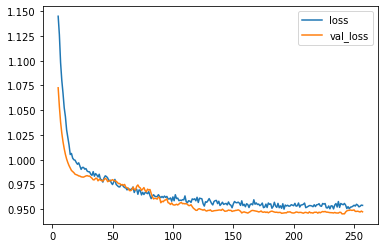

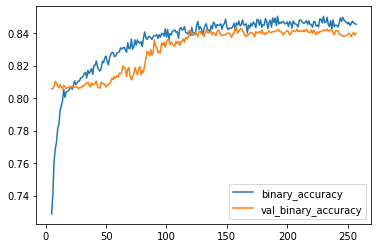

In [27]:
#Plot our training history
history_df = pd.DataFrame(history.history)
history_df.loc[5:, ['loss', 'val_loss']].plot()
history_df.loc[5:, ['binary_accuracy', 'val_binary_accuracy']].plot()

print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}")\
      .format(history_df['val_loss'].min(), 
              history_df['val_binary_accuracy'].max()))

Our ANN stops training after around 250 epochs with 84% accuracy

# Hyperparameter tuning

In [28]:
# Passing values to KerasClassifier 
ann = KerasClassifier(build_fn = ANN, batch_size = 256, epochs = 1000)

In [29]:
# # Passing values to KerasClassifier 
# ann = KerasClassifier(build_fn = ANN, batch_size = 512, epochs = 1000)

# # Using Grid Search CV to getting the best parameters
# parameters = {'optimizer': ['adam', 'rmsprop','sgd'],
#               'batch_size': [256, 512],
#               'loss': ['binary_crossentropy','hinge','squared_hinge']}

# grid_search = GridSearchCV(estimator = ann, param_grid = parameters, scoring = 'accuracy', cv = 5, n_jobs = -1)

# grid_search.fit(X_train, y_train)
# grid_search.best_params_

best_params: {'batch_size': 256, 'loss': 'hinge', 'optimizer': 'rmsprop'}

# Model assessment

              precision    recall  f1-score   support

           0       0.84      0.98      0.91      1569
           1       0.83      0.33      0.47       424

    accuracy                           0.84      1993
   macro avg       0.84      0.66      0.69      1993
weighted avg       0.84      0.84      0.82      1993



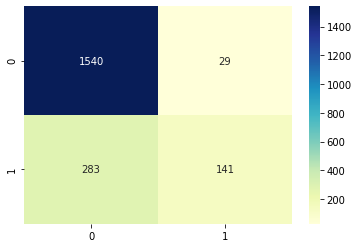

In [30]:
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)
cm = confusion_matrix(y_test, y_pred)

print(classification_report(y_test, y_pred))
sns.heatmap(pd.DataFrame(cm), annot=True, cmap="YlGnBu" ,fmt='g')

# Model Interpretation using SHAP

Explaining a single prediction

In [31]:
import shap 

shap.initjs()

# we use a selection of 200 samples from the dataset to represent “typical” feature values
#We will display the first row data
explainer = shap.KernelExplainer(model.predict, shap.kmeans(X_train, 200))
shap_values = explainer.shap_values(X_test.iloc[0,:])
shap.force_plot(explainer.expected_value[0], shap_values[0], X_test.iloc[0,:])

Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


SHAP Summary Plots
- to save time we just take 30 samples

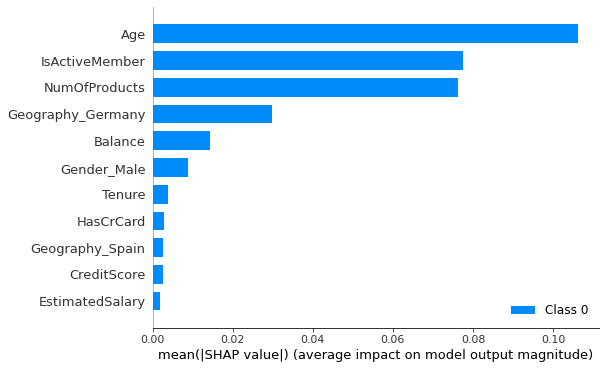

In [32]:
shap_values_sum = explainer.shap_values(X_test.iloc[300:330,:])
shap.summary_plot(shap_values_sum, X_test.iloc[300:330,:])